# Code

In [1]:
from commonfunctions import *
from skimage.exposure import histogram
from skimage.measure import find_contours
from skimage.draw import rectangle
from skimage.morphology import binary_opening, binary_erosion, binary_closing, thin
from skimage.filters import gaussian as gaussian_filter
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [9]:
def movePointBy90(hieght, width, i, j):
    iNew = -j + width - 1
    jNew = i
    return int(iNew), int(jNew)

def rotateMatrix90(mat):
    image2 = np.zeros([mat.shape[1], mat.shape[0]])
    for i in range(mat.shape[0]-1):
        for j in range(mat.shape[1]-1):
            newPoint = movePointBy90(mat.shape[0], mat.shape[1], i, j)
            image2[newPoint[0], newPoint[1]]=mat[i,j]
    return image2
def rotateMatrixNTimes(mat, n=1):
    for i in range(0, n):
        mat = rotateMatrix90(mat)
    return mat

def getChars(img):
    charTexts = []
    contours = find_contours(img, 0.8)
    with_boxes  = np.zeros(img.shape, dtype=float)
    bounding_boxes = []
    for contour in contours:
        Xmin = int(np.min(contour[:,1]))
        Xmax = int(np.max(contour[:,1]))
        Ymin = int(np.min(contour[:,0]))
        Ymax = int(np.max(contour[:,0]))
        bounding_boxes.append([Xmin, Xmax, Ymin, Ymax])
    i = 0
    for box in bounding_boxes:
        [Xmin, Xmax, Ymin, Ymax] = box
        absWidthDifference = abs(Ymax-Ymin)
        if(absWidthDifference == 0):
            absWidthDifference = 1
        
        if(abs(Xmax-Xmin)/absWidthDifference >= 0.1 and abs(Xmax-Xmin)/absWidthDifference <= 1.9 and abs(Ymax-Ymin) > 12):
            rr, cc = rectangle(start = (Ymin,Xmin), end = (Ymax,Xmax), shape=with_boxes.shape)
            with_boxes[rr, cc] = 1 #set color black
            char = img[rr,cc]
            char = rotateMatrixNTimes(char, 3)
            char = np.fliplr(char)
            rows, cols = char.shape
            char = char[1:rows-1,1:cols-1] # Cancel black borders (thickness is only 1 pixel)
            textChar = detectChar(char)
            charTexts.append(textChar)
            show_images([char], ["Char"])
            i = i + 1
    print(i)
    show_images([with_boxes , with_boxes * img], ["With boxes", "show value"])
    return charTexts


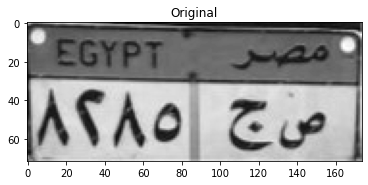

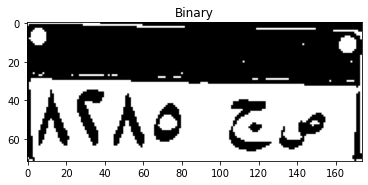

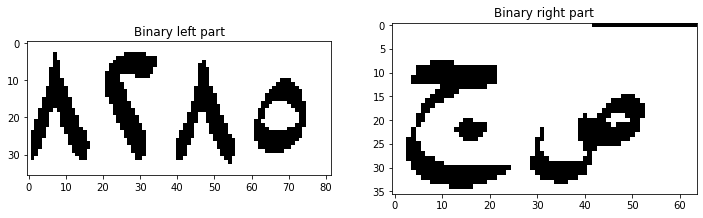

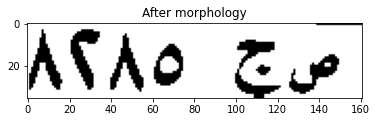

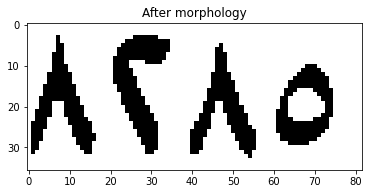

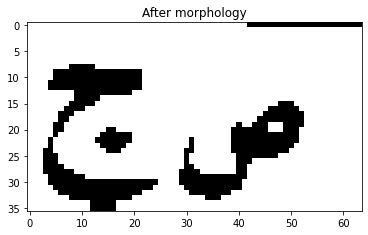

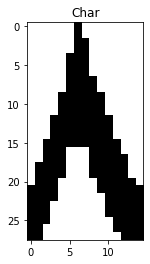

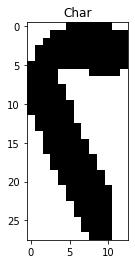

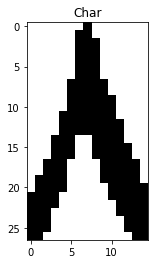

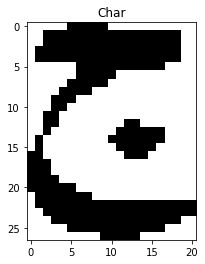

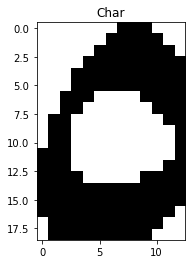

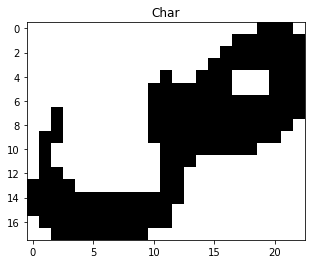

6


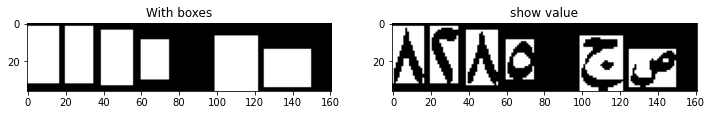

[8, 2, 8, 14, 5, 23]


In [13]:
image = (rgb2gray(io.imread("plates_dataset/img2.jpg")) * 255).astype("uint8")
show_images([image], ["Original"])
# TODO: Try to get the threshold by any technique rather than static thresholding
image = image > 110
show_images([image], ["Binary"])
x,y = image.shape
rightPart = image[int(x//2.2):x-int(x//15),int(y//1.7):y-int(y//20)]
leftPart = image[int(x//2.2):x-int(x//15),int(y//30):int(y//2)]
image = image[int(x//2.2):x-int(x//15),int(y//30):y-int(y//20)]
show_images([leftPart, rightPart], ["Binary left part", "Binary right part"])
structuringEl = np.ones((2, 2))        
leftPart = binary_opening(leftPart, structuringEl)
rightPart = binary_opening(rightPart, structuringEl)
image = binary_opening(image, structuringEl)
show_images([image], ["After morphology"])
show_images([leftPart], ["After morphology"])
show_images([rightPart], ["After morphology"])
#print(getChars(leftPart))
#print(getChars(rightPart))
print(getChars(image))

#show_images([leftPart, with_boxes], ["Before boxes", "With only objects"])


In [3]:
def getAverageError(list1, list2):
    errorList = np.absolute(list1 - list2)
    return (np.average(errorList))

def detectCharText(directions):
    codes = np.zeros([38, 8]) # 38 char and digit, every one has 8 directions
    codes[2] = np.array([0.07417582, 0.00549451, 0.04945055, 0, 0.0521978, 0, 0, 0.00274725])
    codes[5] = np.array([0.06868132, 0.01648352, 0.02197802, 0, 0.02472527, 0, 0, 0])
    codes[8] = np.array([0.06666667, 0.02716049, 0, 0, 0.00246914, 0, 0.01234568, 0.00246914])
    codes[10] = np.array([0.44827586, 0.01724138, 0, 0, 0.01724138, 0, 0, 0.24137931])
    codes[14] = np.array([0.00881834, 0.01058201, 0.00176367, 0, 0.00352734, 0, 0.00352734, 0.00176367])
    codes[17] = np.array([0.02, 0.0075, 0.0025, 0, 0.0025, 0, 0.005, 0.0025])
    codes[23] = np.array([0.04830918, 0.04589372, 0.01932367, 0, 0.01932367, 0, 0.00483092, 0.00724638])
    errorAveragesList = np.zeros(38)
    for i in range(0, 38):
        errorAveragesList[i] = getAverageError(directions, codes[i])
    return np.argmin(errorAveragesList) # returns minimum value index

def getFirstPosition(charImage):
    rows, cols = charImage.shape
    startX = 0
    startY = 0
    found = False
    for i in range(0, rows):
        if found == True:
            break
        for j in range(0, cols):
            if(charImage[i][j] == 0):
                startX = i
                startY = j
                found = True
                break
    return startX, startY

def checkRange(i, j, rows, cols):
    return i >=0 and i < rows and j >= 0 and j < cols


def getBlackIndex(currentX, currentY, charImage, isVisited):
    rows, cols = charImage.shape
    neighboursY = [0, -1, -1, -1, 1, 1, 1, 0]
    neighboursX = [1, 0, -1, 1, 0, 1, -1, -1]
    for i in range(0, 8):
        x = currentX + neighboursX[i]
        y = currentY + neighboursY[i]
        if(checkRange(x, y, rows, cols) and (isVisited[x][y] == 0) and (charImage[x][y] == 0)):
            return i, x, y
    return -1, -1, -1

def getDirections(startX, startY, charImage):
    rows, cols = charImage.shape
    directions = np.zeros(8)
    currentX = startX
    currentY = startY
    isVisited = np.zeros([rows, cols])
    isVisited[currentX][currentY] = 1
    while currentX < rows and currentY < cols:
        blackIndex, currentX, currentY = getBlackIndex(currentX, currentY, charImage, isVisited)
        if blackIndex == -1:
            break
        directions[blackIndex] += 1
        isVisited[currentX][currentY] = 1
    normalizedDirections = directions / (rows * cols)
    return normalizedDirections

def detectChar(charImage):
    rows, cols = charImage.shape
    startX, startY = getFirstPosition(charImage)
    directionsCount = getDirections(startX, startY, charImage) # directionsCount = [NS, SN, EW, WE, NSWE, NESW, SENW, SWNE]
    return detectCharText(directionsCount)
'''dal = (rgb2gray(io.imread("dal.jpg")) * 255).astype("uint8")
show_images([dal], ["Original"])
dal = dal < 70
show_images([dal], ["Binary"])
thinnedDal = thin(dal, 150)
show_images([thinnedDal], ["Binary"])
detectChar(dal)'''
    
    

'dal = (rgb2gray(io.imread("dal.jpg")) * 255).astype("uint8")\nshow_images([dal], ["Original"])\ndal = dal < 70\nshow_images([dal], ["Binary"])\nthinnedDal = thin(dal, 150)\nshow_images([thinnedDal], ["Binary"])\ndetectChar(dal)'